In [2]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

# Scintillator Data

In [3]:
data_1=joblib.load("waveform_process_result_BCF92.joblib")
data_2=joblib.load("waveform_process_result_Y11.joblib")
time_series = data_1["time_series"]

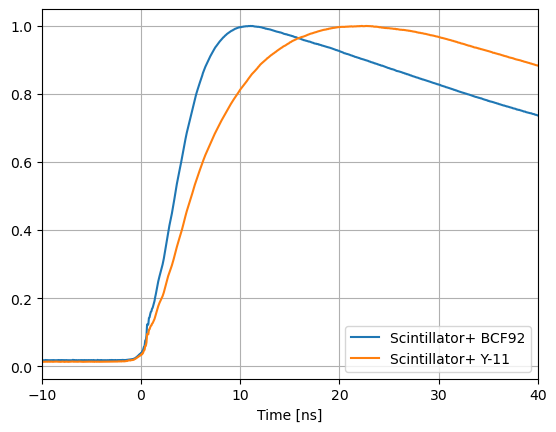

In [4]:
plot(time_series+4, data_1["avg_pulse_1"]/max(data_1["avg_pulse_1"]), label="Scintillator+ BCF92")
plot(time_series+4, data_2["avg_pulse_1"]/max(data_2["avg_pulse_1"]), label="Scintillator+ Y-11")
xlabel("Time [ns]")
xlim(-10,40)
legend()
grid()

In [9]:
data_1.keys()

dict_keys(['trigger_time_edge_1', 'trigger_time_cfd_1', 'trigger_time_fit_1', 'amplitude_1', 'integral_1', 'amplitude_fit_1', 'trise_fit_1', 'tfall_fit_1', 'fit_chi2_1', 'trigger_time_edge_2', 'trigger_time_cfd_2', 'trigger_time_fit_2', 'amplitude_2', 'integral_2', 'amplitude_fit_2', 'trise_fit_2', 'tfall_fit_2', 'fit_chi2_2', 'dt', 'amp', 'amp_mean', 'pe_ch1_int', 'pe_ch2_int', 'pe_min', 'avg_pulse_1', 'time_series'])

In [11]:
data_1["pe_avg"] = 0.5*(data_1["pe_ch1_int"]+data_1["pe_ch2_int"])
data_2["pe_avg"] = 0.5*(data_2["pe_ch1_int"]+data_2["pe_ch2_int"])

Text(0, 0.5, 'Counts')

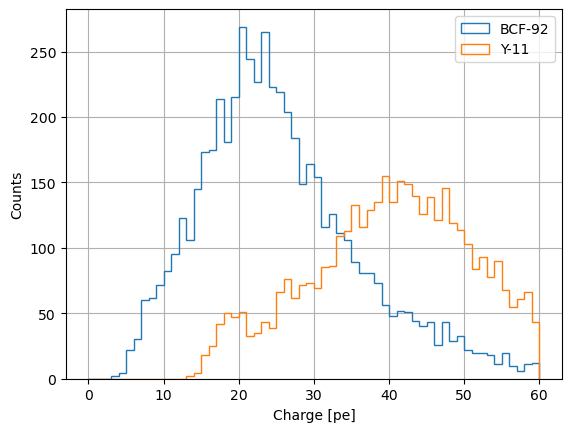

In [18]:
hist(data_1["pe_avg"][abs(data_1["dt"])<4],bins=60,range=(0,60),histtype="step",label="BCF-92");

y11_corr = (data_2["pe_avg"][abs(data_2["dt"])<4]+ np.mean(data_1["pe_avg"][abs(data_1["dt"])<10])*0.35)
hist(y11_corr,bins=60,range=(0,60),histtype="step",label="Y-11");
xlabel("Charge [pe]")
legend()
grid()
ylabel("Counts")


In [145]:
process_result = {}
for ch in [1,2]:
    process_result[f"trigger_time_edge_{ch}"]=[]
    process_result[f"trigger_time_cfd_{ch}"]=[]
    process_result[f"trigger_time_fit_{ch}"]=[]
    process_result[f"amplitude_{ch}"]=[]
    process_result[f"integral_{ch}"]=[]
    process_result[f"amplitude_fit_{ch}"]=[]
    process_result[f"trise_fit_{ch}"]=[]
    process_result[f"tfall_fit_{ch}"]=[]
    process_result[f"fit_chi2_{ch}"]=[]
    

for i in tqdm(range(len(data_save[2]))):
# for i in tqdm(range(1000)):
    for ch in [1,2]:
        x=time_series
        y=-data_save[ch][i]
        y-=np.mean(y[:2000])
        # y=scipy.ndimage.gaussian_filter(y, 7)

        dt = (time_series[1]-time_series[0])
        

        # Edge trigger:
        trigger_time_edge = (np.argmax( y>trigger_threshold_edge)-2048)*dt
        amplitude = np.max(y)
        integral = np.sum(y)
    
        
        process_result[f"trigger_time_edge_{ch}"].append(trigger_time_edge)
        # process_result[f"trigger_time_cfd_{ch}"].append(trigger_time_cfd)
        # process_result[f"trigger_time_fit_{ch}"].append(trigger_time_fit)
        process_result[f"amplitude_{ch}"].append(amplitude)
        process_result[f"integral_{ch}"].append(integral)
        # process_result[f"amplitude_fit_{ch}"].append(popt[0])
        # process_result[f"trise_fit_{ch}"].append(popt[2])
        # process_result[f"tfall_fit_{ch}"].append(popt[3])
        # process_result[f"fit_chi2_{ch}"].append(chi2)        
        
for key in process_result:
    process_result[key]=np.array(process_result[key])  


dt = process_result[f"trigger_time_edge_1"]-process_result[f"trigger_time_edge_2"]     
amp = np.min([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 
amp_mean = np.mean([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 
pe_ch1_int =  process_result[f"integral_1"]/integral_1pe
pe_ch2_int =  process_result[f"integral_2"]/integral_1pe
pe_min = np.min([pe_ch1_int, pe_ch2_int],axis=0) 

100%|██████████| 7200/7200 [00:00<00:00, 30129.57it/s]


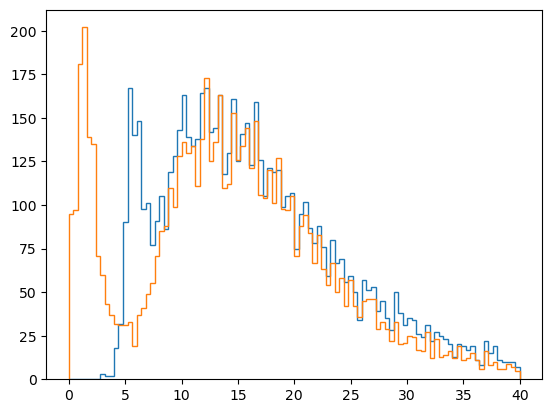

In [154]:
hist(pe_ch1_int, range=(0,40),bins=100,histtype="step");
hist(pe_min, range=(0,40),bins=100,histtype="step");
# hist(process_result["amplitude_1"]/0.003, range=(0,40),bins=50,histtype="step");

In [141]:
# hist(process_result["amplitude_2"],bins=120,range=(0,0.04),histtype="step");
# axvline(0.0093)
# axvline(0.0124)
# amp_1pe = 0.0124-0.0093
# print(amp_1pe)
# hist(amp,bins=100);

Text(0.5, 0, 'Charge [pe]')

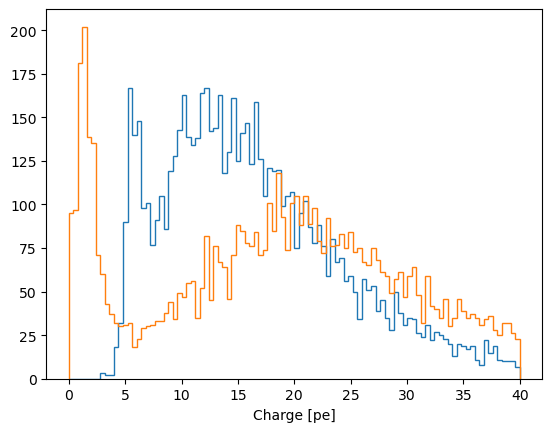

In [149]:
hist(pe_ch1_int,bins=100,range=(0,40),histtype="step");
hist(pe_ch2_int,bins=100,range=(0,40),histtype="step");

# yscale("log")
xlabel("Charge [pe]")

Text(0, 0.5, 'dt [ns]')

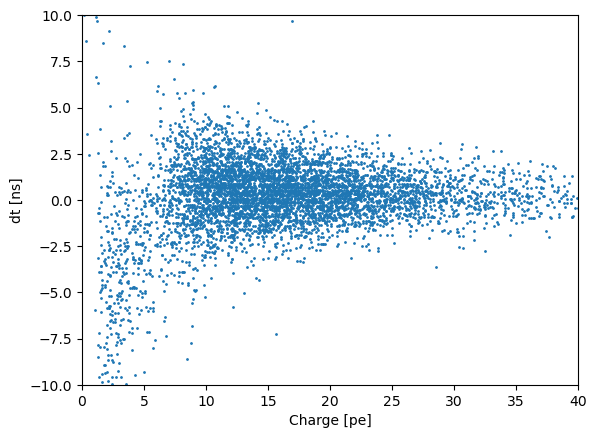

In [152]:
scatter(pe_min, dt,s=1)
xlim(0,40)
ylim(-10,10)
xlabel("Charge [pe]")
ylabel("dt [ns]")

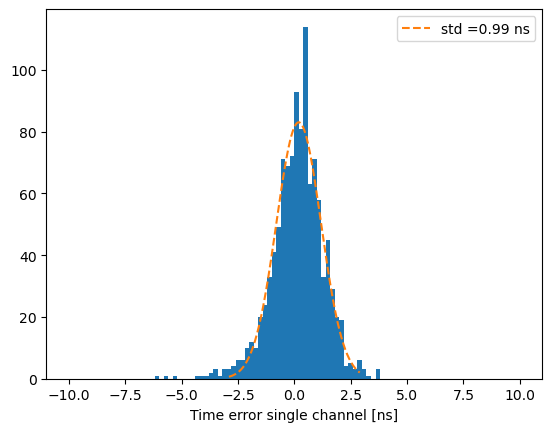

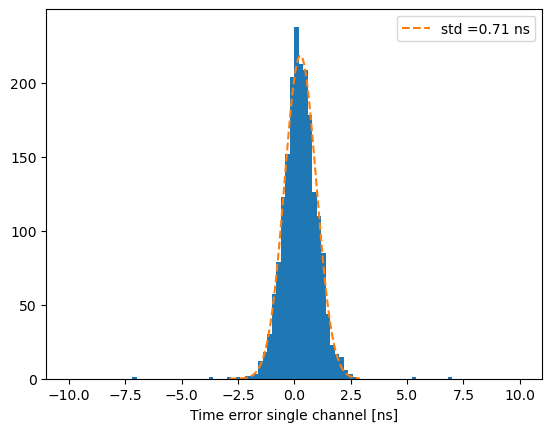

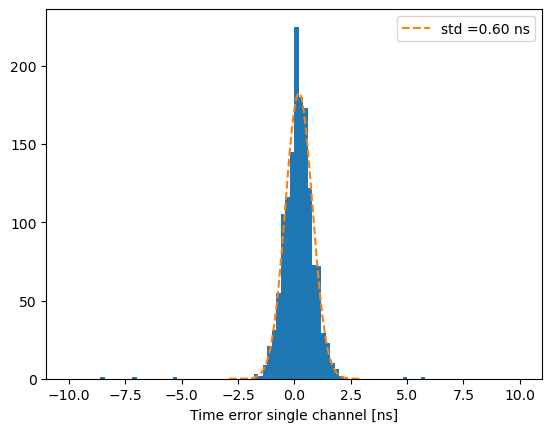

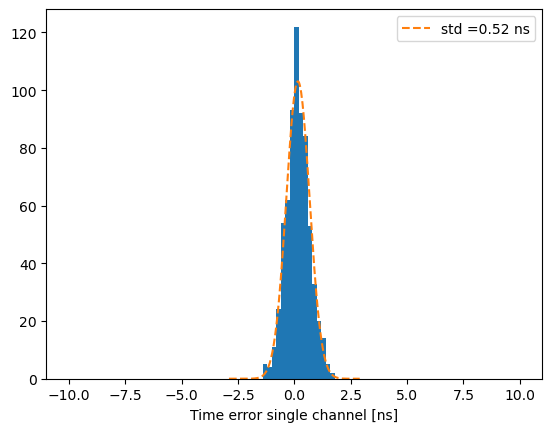

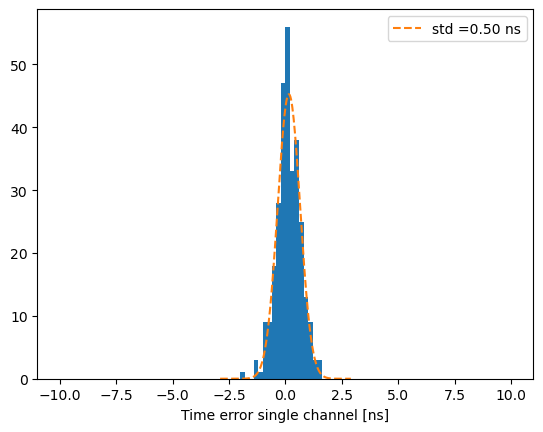

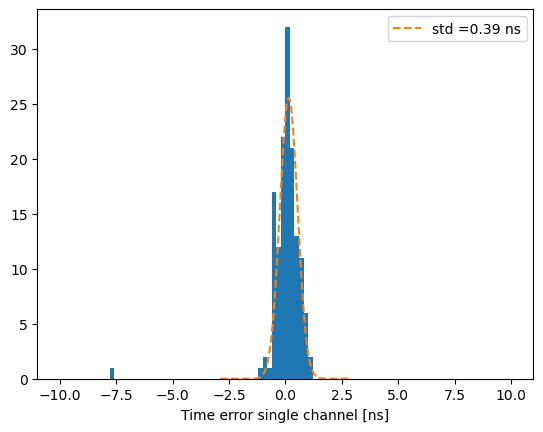

In [157]:
# mask = amp>0.02

# h=hist(dt[mask]/sqrt(2), range=(-10,10),bins=100);
# popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-3,3), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");
# legend()
# xlabel("Time error single channel [ns]")
# show()

cut_edges = np.linspace(5,40,7)
amps = []
sigmas = []

for icut  in range(len(cut_edges)-1):
    mask = (pe_min>cut_edges[icut])&(pe_min<cut_edges[icut+1])
    # mask = (amp_mean>cut_edges[icut])&(amp_mean<cut_edges[icut+1])

    h=hist(dt[mask]/2, range=(-10,10),bins=100);

    popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-3,3), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");

    amps.append(np.mean(pe_min[mask]))
    sigmas.append(popt[2])

    legend()
    xlabel("Time error single channel [ns]")
    show()


Text(0, 0.5, 'Counts')

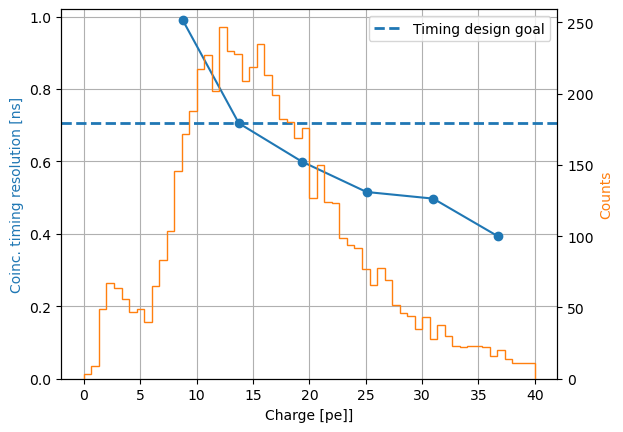

In [161]:


plot(amps, sigmas, marker="o")
axhline(1/sqrt(2), label="Timing design goal", color="C0", linewidth=2, linestyle="--")

legend()
ylim(0,)
xlabel("Charge [pe]]")
ylabel("Coinc. timing resolution [ns]")
grid()
gca().yaxis.label.set_color("C0")


gca().twinx()
hist(pe_min[abs(dt)<10],bins=60,range=(0,40),histtype="step",color="C1");
gca().yaxis.label.set_color("C1")
ylabel("Counts")


# Check waveform
### Try the fit on one event

/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:48: RuntimeWarning: overflow encountered in exp
  kernel = (np.exp(-dx/tau1)-np.exp(-dx/tau2))/(tau1-tau2)*np.heaviside(dx,1)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:49: RuntimeWarning: divide by zero encountered in true_divide
  kernel_normed = kernel/np.max(kernel)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:49: RuntimeWarning: invalid value encountered in true_divide
  kernel_normed = kernel/np.max(kernel)


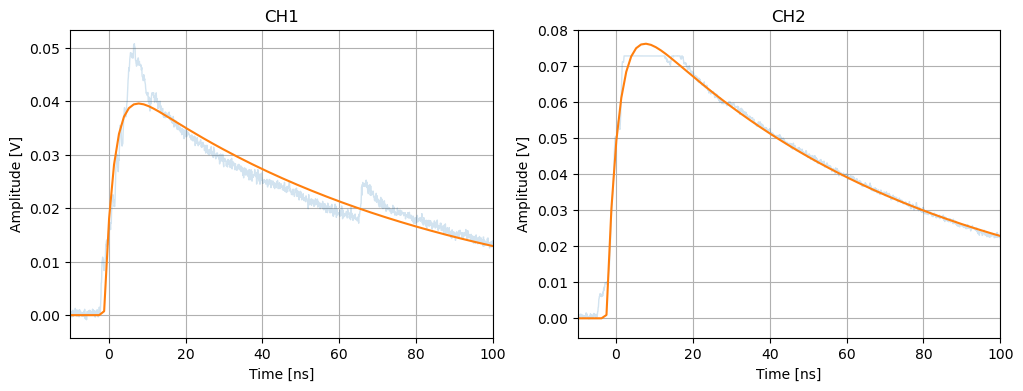

In [13]:
# for i in range(len(data_save[1])):
fig,axs = subplots(1,2,figsize=(12,4))

for iax in [0,1]:
    sca(axs[iax])
    for i in range(1,2):
        x=time_series
        y=-data_save[iax+1][i]
        plot(x, y ,alpha=0.2, linewidth=1)
        
        popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 5., 30], makeplot=True)        
        
    title(f"CH{iax+1}")

    xlim(-10,100)
    xlabel("Time [ns]")
    ylabel("Amplitude [V]")
    grid()
show()



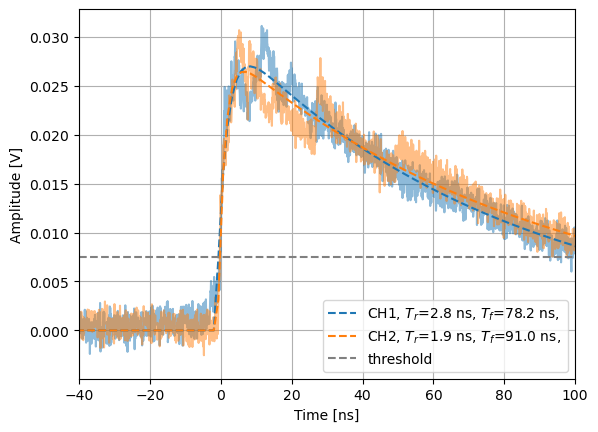

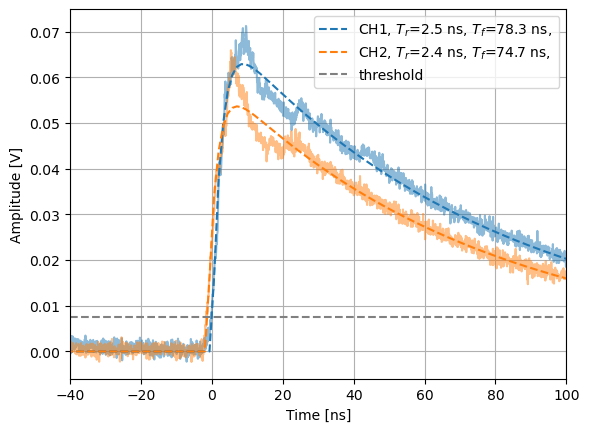

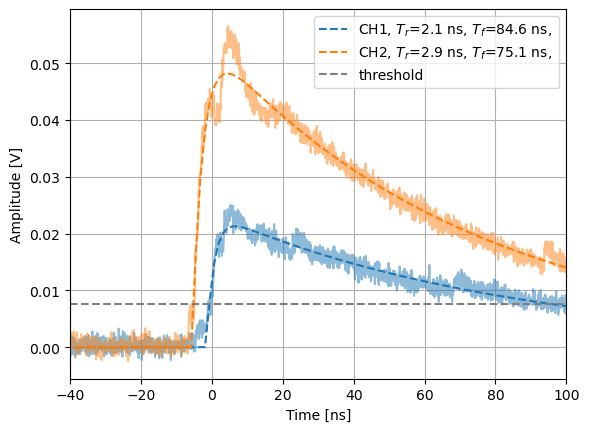

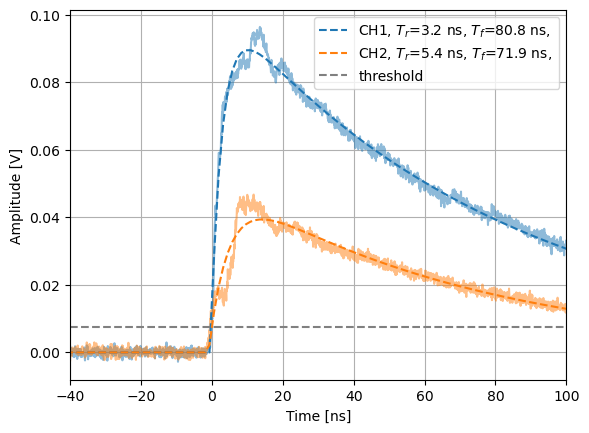

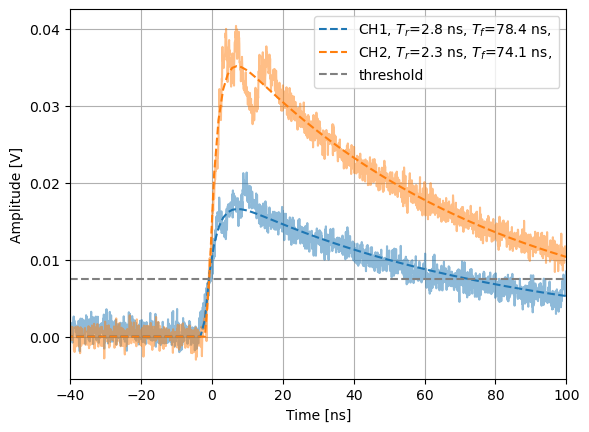

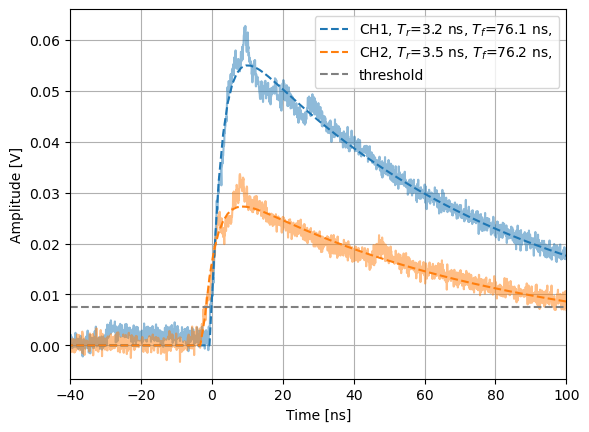

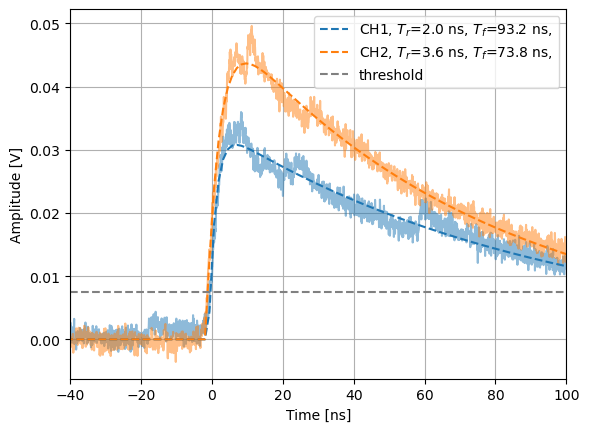

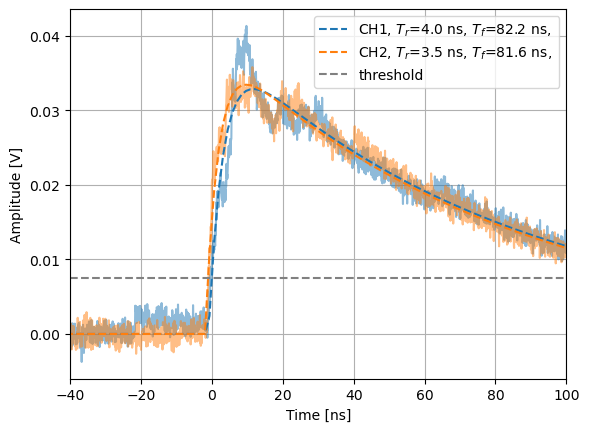

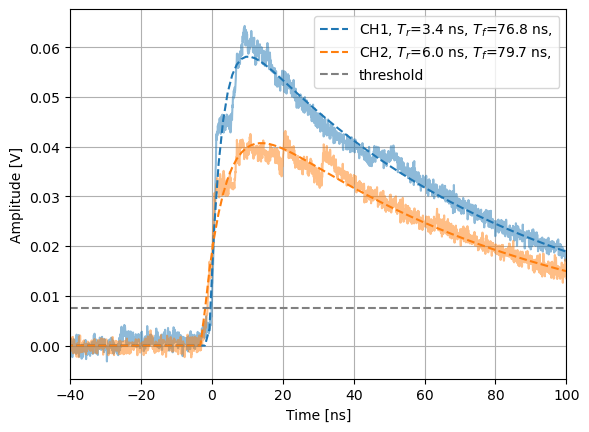

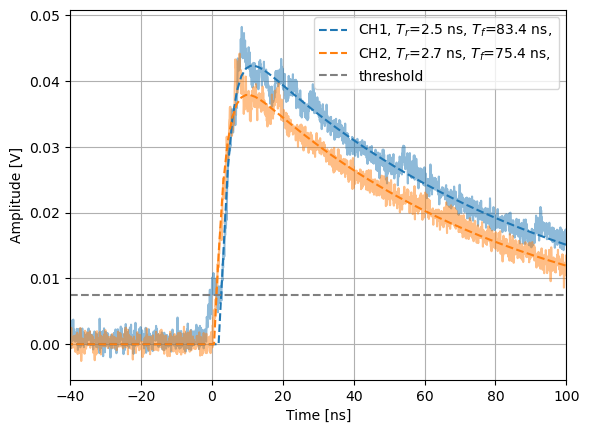

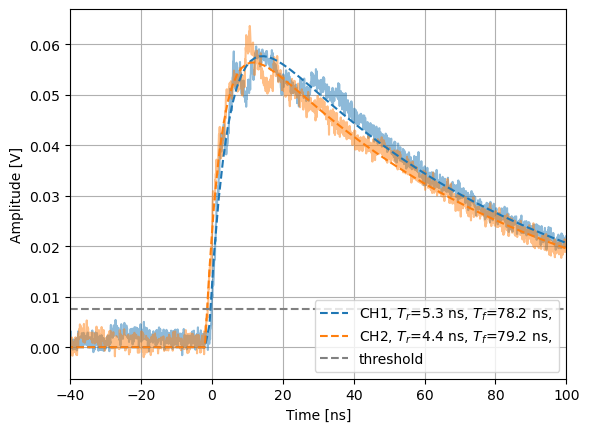

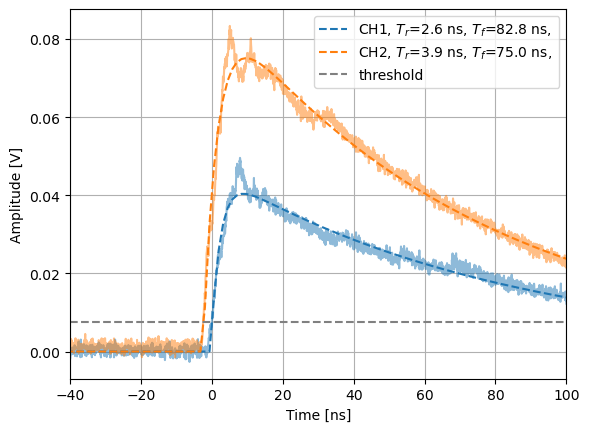

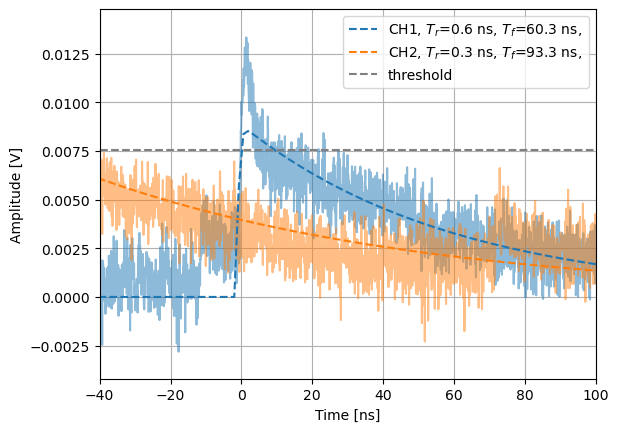

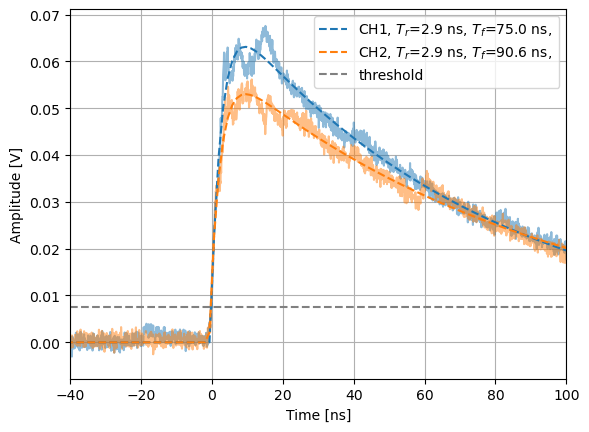

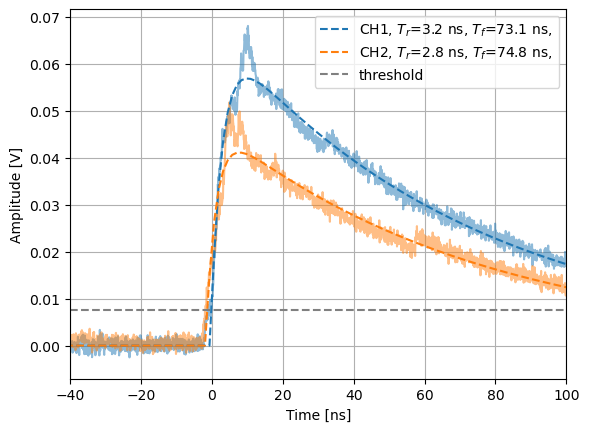

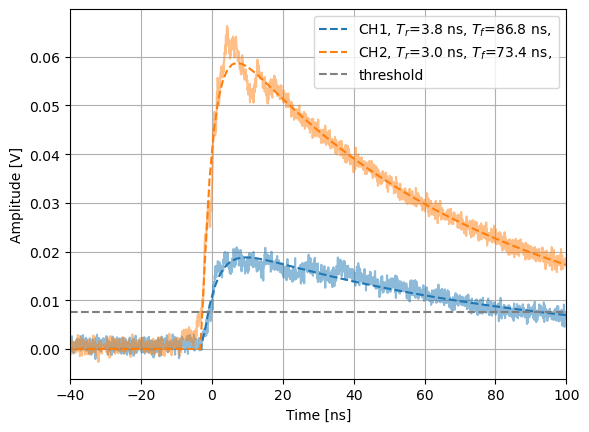

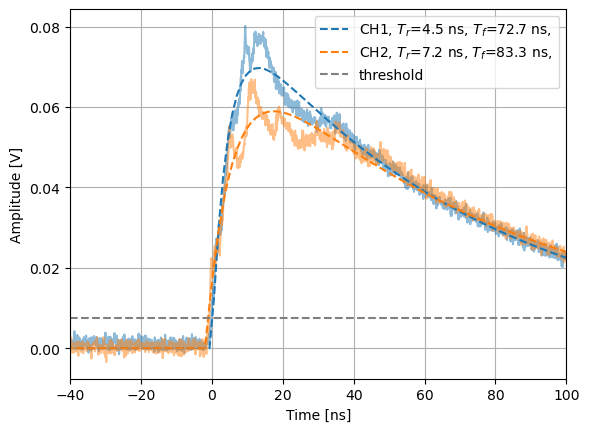

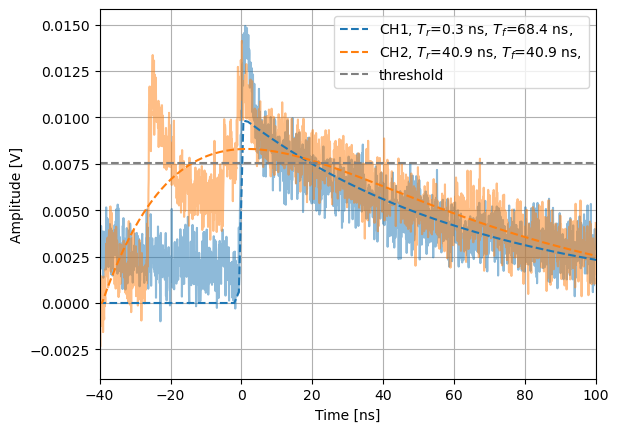

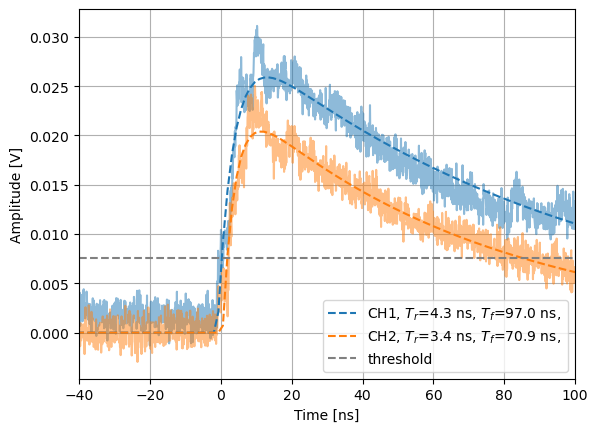

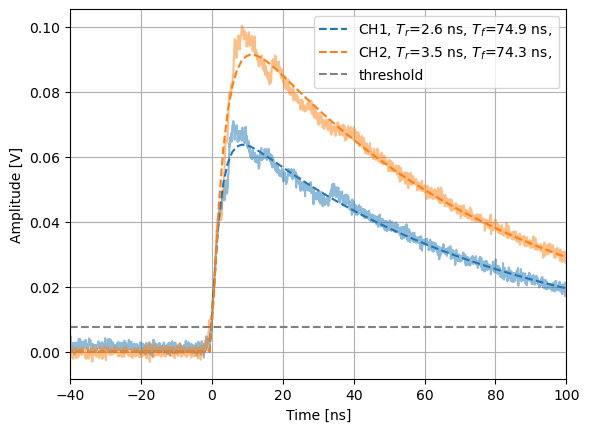

In [240]:

for i in range(20):
    
    if max(-data_save[2][i])>trigger_threshold_edge:
        # CFD trigger
        plot(time_series, -data_save[1][i], alpha=0.5)
        plot(time_series, -data_save[2][i], alpha=0.5)
        
        x=time_series
        y=-data_save[1][i]
        popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 3.5, 70], makeplot=True, color="C0", linestyle="--", label="CH1, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ")           
        y=-data_save[2][i]
        popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 3.5, 70], makeplot=True, color="C1", linestyle="--", label="CH2, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ")           
        
        axhline(trigger_threshold_edge, linestyle="--", color="grey", label="threshold")
        xlim(-40,100)
        xlabel("Time [ns]")
        ylabel("Amplitude [V]")
        grid()
        legend()
        show()

In [3]:
trigger_threshold_edge = amp2eh*4.5
trigger_threshold_cfd  = 0.5



process_result = {}
for ch in [1,2]:
    process_result[f"trigger_time_edge_{ch}"]=[]
    process_result[f"trigger_time_cfd_{ch}"]=[]
    process_result[f"trigger_time_fit_{ch}"]=[]
    process_result[f"amplitude_{ch}"]=[]
    process_result[f"amplitude_fit_{ch}"]=[]
    process_result[f"trise_fit_{ch}"]=[]
    process_result[f"tfall_fit_{ch}"]=[]
    process_result[f"fit_chi2_{ch}"]=[]
    

for i in tqdm(range(len(data_save[2]))):
# for i in tqdm(range(1000)):
    for ch in [1,2]:
        x=time_series
        y=-data_save[ch][i]
        dt = (time_series[1]-time_series[0])
        
        

        # Edge trigger:
        trigger_time_edge = (np.argmax( y>trigger_threshold_edge)-2048)*dt
        amplitude = np.max(y)
    
    
        # CFD trigger
        leading_edges = hp.constant_fraction_discriminator(y, 0, trigger_threshold_edge, trigger_threshold_cfd, gauss_filter=8)
        if len(leading_edges)>0:
            trigger_time_cfd = (leading_edges[0][1]-2048)*(time_series[1]-time_series[0])
        else:
            trigger_time_cfd = -999
           
        # Fit
        try:
            popt, pcov, info, f = hp.fit_curve(hp.Pulse,x,y, p0=[np.max(y), x[np.argmax(y)], 3.5, 70], maxfev=1000, makeplot=False, color="C0", linestyle="--", label="CH1, $T_r$={popt[2]:.1f} ns, $T_f$={popt[3]:.1f} ns, ") 
            chi2=np.linalg.norm(info["fvec"])
        except KeyboardInterrupt:
            print("  KeyboardInterrupt. You pressed ctrl c...")
            break                
        except Exception as e: # Any other exception
            # print("  Exception:", str(e)) # Displays the exception without raising it
            popt = [-999, -999, -999, -999]
            chi2=-999
            
        trigger_time_fit = popt[1]
        
        process_result[f"trigger_time_edge_{ch}"].append(trigger_time_edge)
        process_result[f"trigger_time_cfd_{ch}"].append(trigger_time_cfd)
        process_result[f"trigger_time_fit_{ch}"].append(trigger_time_fit)
        process_result[f"amplitude_{ch}"].append(amplitude)
        process_result[f"amplitude_fit_{ch}"].append(popt[0])
        process_result[f"trise_fit_{ch}"].append(popt[2])
        process_result[f"tfall_fit_{ch}"].append(popt[3])
        process_result[f"fit_chi2_{ch}"].append(chi2)        
    
    
for key in process_result:
    process_result[key]=np.array(process_result[key])
    

  0%|▏                                                                               | 12/7200 [00:00<05:58, 20.02it/s]C:\Users\mathusla\Documents\MATHUSLA\JupyterNotebooks\Hardware\Keysight\..\helper_basic.py:49: RuntimeWarning: divide by zero encountered in true_divide
  kernel_normed = kernel/np.max(kernel)
C:\Users\mathusla\Documents\MATHUSLA\JupyterNotebooks\Hardware\Keysight\..\helper_basic.py:49: RuntimeWarning: invalid value encountered in true_divide
  kernel_normed = kernel/np.max(kernel)
C:\Users\mathusla\Documents\MATHUSLA\JupyterNotebooks\Hardware\Keysight\..\helper_basic.py:48: RuntimeWarning: overflow encountered in exp
  kernel = (np.exp(-dx/tau1)-np.exp(-dx/tau2))/(tau1-tau2)*np.heaviside(dx,1)
  1%|▌                                                                               | 50/7200 [00:02<06:31, 18.28it/s]


KeyboardInterrupt: 

In [37]:
# joblib.dump(process_result, "muon_coinc_ch1_ch2_coin_processed.joblib")
process_result = joblib.load("muon_coinc_ch1_ch2_coin_processed.joblib")

process_result["charge_min"] = np.min([process_result["amplitude_fit_1"],process_result["amplitude_fit_2"]],axis=0)/amp2eh
charge_1 = process_result["amplitude_fit_1"]/amp2eh
charge_2 = process_result["amplitude_fit_2"]/amp2eh
dt_edge = process_result["trigger_time_edge_1"]-process_result["trigger_time_edge_2"]
dt_cfd = process_result["trigger_time_cfd_1"]-process_result["trigger_time_cfd_2"]
dt_fit = process_result["trigger_time_fit_1"]-process_result["trigger_time_fit_2"]

Text(0, 0.5, 'Chi2')

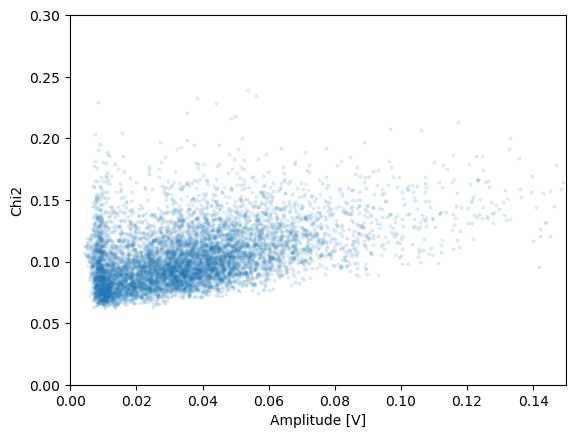

In [5]:
scatter(process_result[f"amplitude_fit_1"],process_result[f"fit_chi2_1"] , s=4, alpha=0.1);
xlim(0,0.15)
ylim(0,0.3)
xlabel("Amplitude [V]")
ylabel("Chi2")

Coincident events 5816


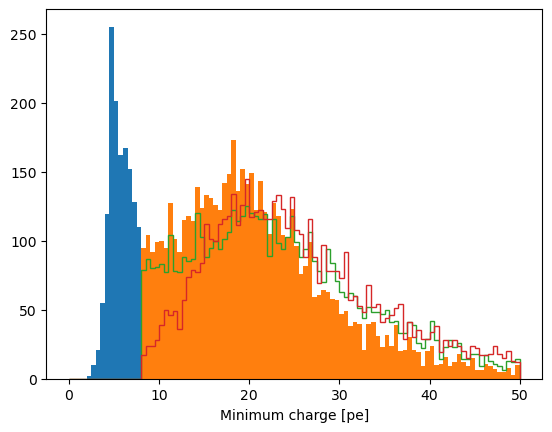

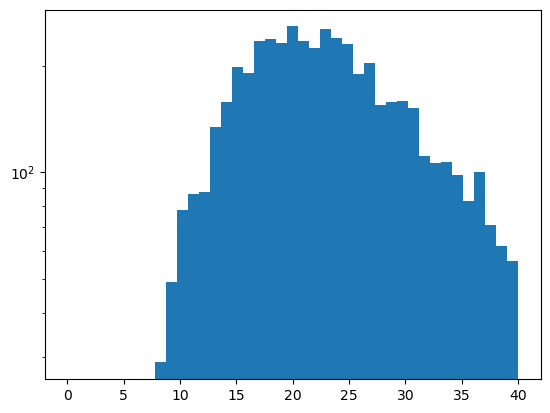

In [6]:
mask_basic = process_result["charge_min"]>0
mask_amp = process_result["charge_min"]>8
hist(process_result["charge_min"][mask_basic], bins=100,range=(0,50));
hist(process_result["charge_min"][mask_basic&mask_amp], bins=100,range=(0,50));
hist(charge_1[mask_basic&mask_amp], bins=100,range=(0,50), histtype="step");
hist(charge_2[mask_basic&mask_amp], bins=100,range=(0,50), histtype="step");
xlabel("Minimum charge [pe]")
print("Coincident events",sum(mask_basic&mask_amp))
show()

hist(process_result[f"amplitude_fit_2"][mask_basic&mask_amp]/amp2eh, range=(0,40),bins=41);
yscale("log")
show()

Text(0, 0.5, 'Trigger delay [ns]')

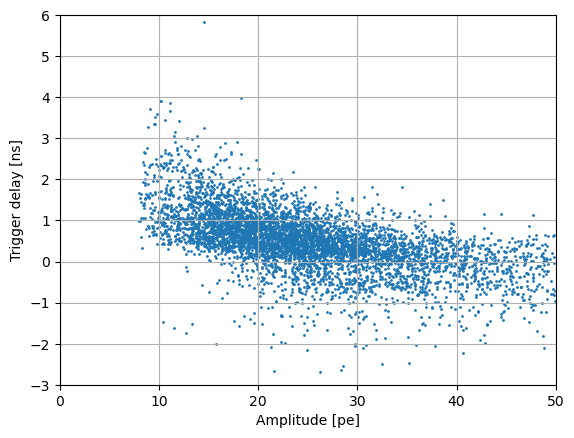

In [216]:
scatter(process_result[f"amplitude_fit_2"][mask_basic&mask_amp]/amp2eh, -(process_result["trigger_time_fit_2"]-process_result["trigger_time_edge_2"])[mask_basic&mask_amp], s=1);
xlim(0,50)
ylim(-3,6)
grid()
xlabel("Amplitude [pe]")
ylabel("Trigger delay [ns]")

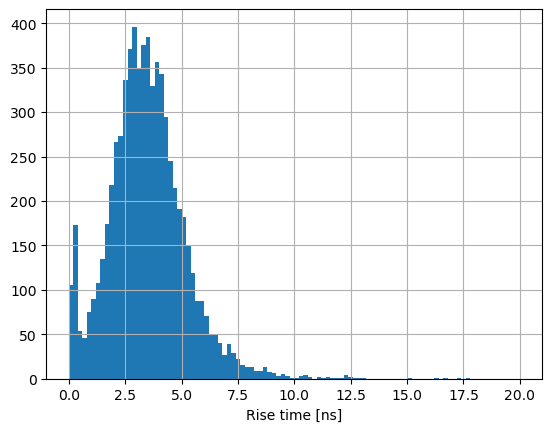

Text(0, 0.5, 'Rise time [ns]')

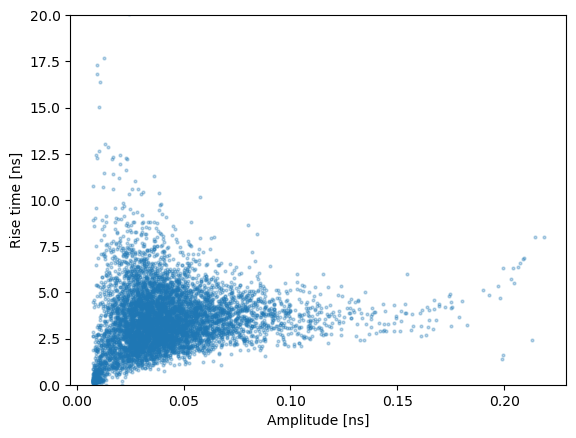

In [212]:
hist(process_result[f"trise_fit_2"][mask_basic&mask_amp],bins=100, range=(0,20));
xlabel("Rise time [ns]")
grid()
np.median(process_result[f"trise_fit_2"][mask_basic&mask_amp])
show()

scatter(process_result[f"amplitude_fit_2"][mask_basic&mask_amp], process_result[f"trise_fit_2"][mask_basic&mask_amp],s=4,alpha=0.3);
ylim(0,20)
xlabel("Amplitude [ns]")
ylabel("Rise time [ns]")


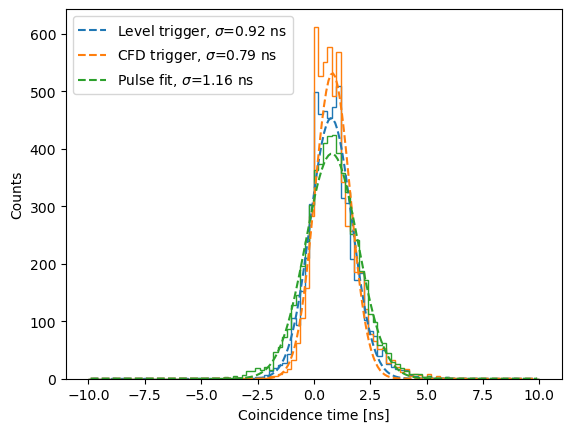

In [217]:
mask = mask_basic&mask_amp
h1 = hist(dt_edge[mask],bins=100,range=(-10,10),histtype="step")#, label="Level trigger");
h2 = hist(dt_cfd[mask], bins=100,range=(-10,10),histtype="step")#, label="CFD trigger");
h3 = hist(dt_fit[mask], bins=100,range=(-10,10),histtype="step")#, label="Fit");


popt, pcov, info, f = hp.fit_hist("gauss", h1, label="Level trigger, $\sigma$={popt[2]:.2f} ns", color="C0", linestyle="--");
popt, pcov, info, f = hp.fit_hist("gauss", h2, label="CFD trigger, $\sigma$={popt[2]:.2f} ns", color="C1", linestyle="--");
popt, pcov, info, f = hp.fit_hist("gauss", h3, label="Pulse fit, $\sigma$={popt[2]:.2f} ns", color="C2", linestyle="--");


legend()
xlabel("Coincidence time [ns]")
ylabel("Counts")
legend()

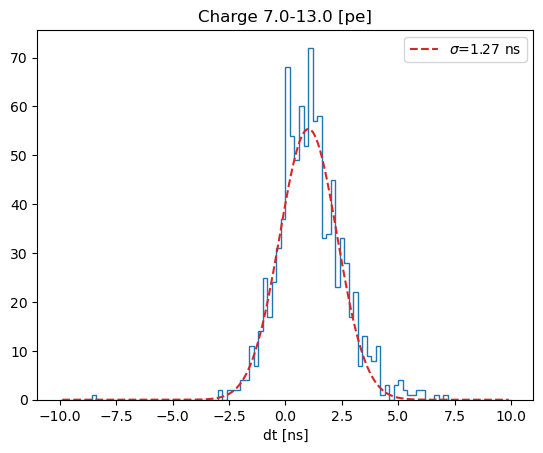

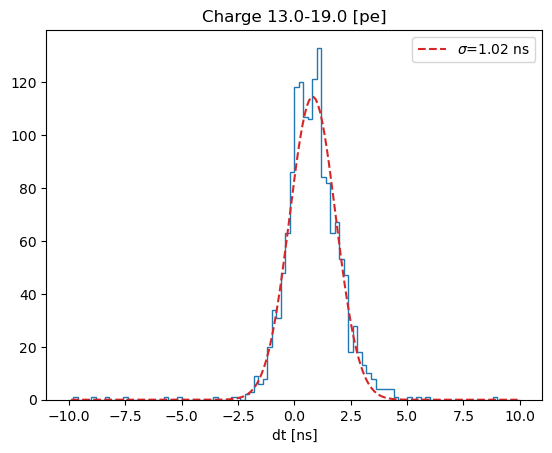

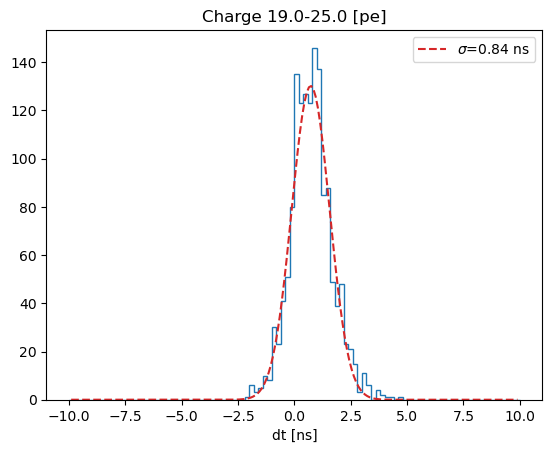

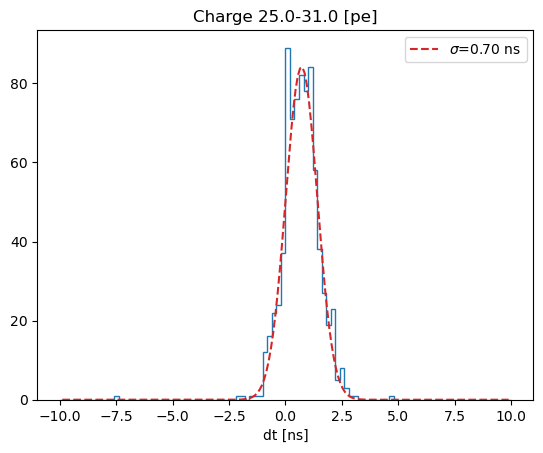

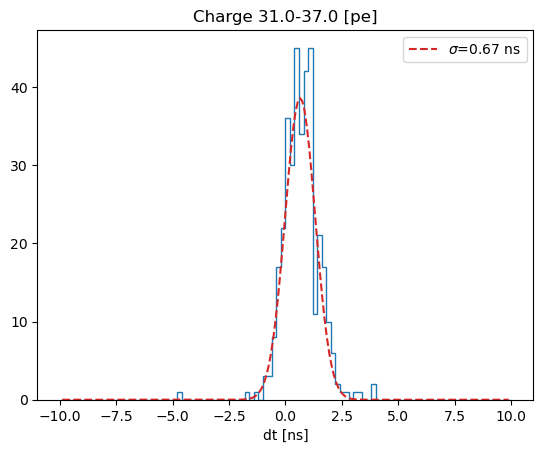

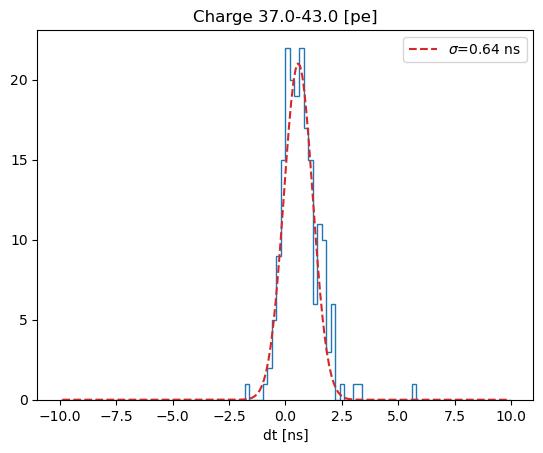

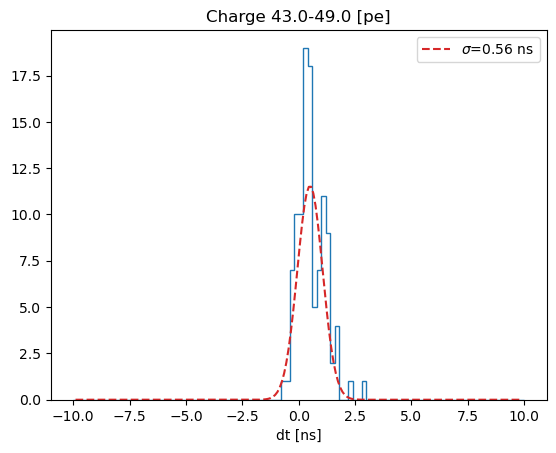

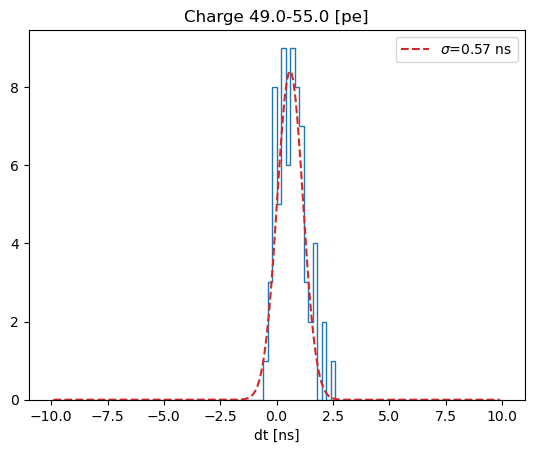

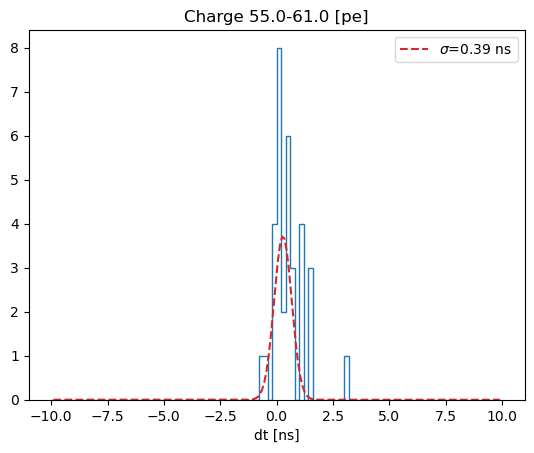

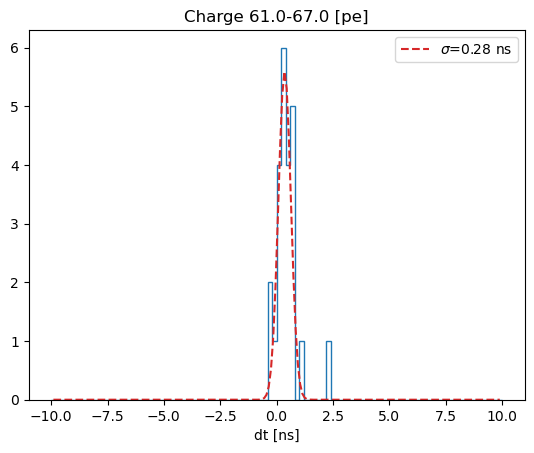

In [252]:
list_charge=[]
list_sigma = []
for i in range(10):
    gap=6
    mask = mask_basic&mask_amp  & (np.abs(process_result["charge_min"]-(10+i*gap))<(gap/2))
    
    h = hist(dt_edge[mask],bins=100,range=(-10,10),histtype="step")#, label="Level trigger");
    # h = hist(dt_cfd[mask],bins=100,range=(-10,10),histtype="step")#, label="Level trigger");
    popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
    legend()
    title(f"Charge {10+gap*i-gap/2}-{10+gap*i+gap/2} [pe]")
    xlabel("dt [ns]")
    show()
    
    avg_charge = np.mean(process_result["charge_min"][mask])
    list_charge.append(avg_charge)
    list_sigma.append(popt[2])    
    


In [253]:
asic_x = [10.637566137566138,14.91830065359477,19.236702716854975,23.62449183189924,28.042489908646694,32.39913097454997,36.81410934744268,41.39618406285073,45.86388888888889,50.20216049382716]
asic_y = [2.743319429739525,1.6240964592967233,1.0933655439605,0.9537349832921947,0.793846111088904,0.7359925131433974,0.6397056522301402,0.5640768276312181,0.5327043052678697,0.5025759310368004]


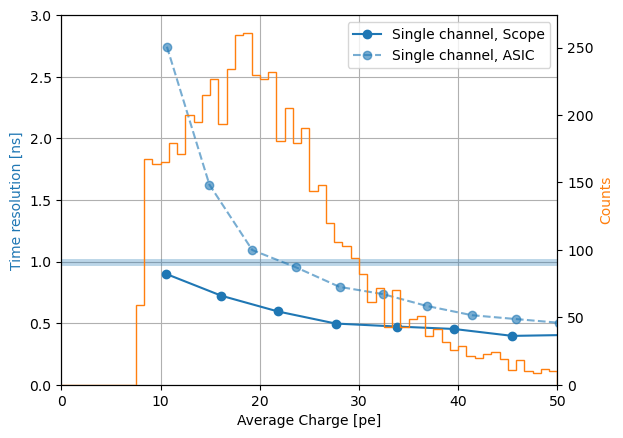

In [254]:
list_charge=np.array(list_charge)
list_sigma=np.array(list_sigma)
plot(list_charge, list_sigma/np.sqrt(2), marker="o", color="C0", label="Single channel, Scope")
plot(asic_x, asic_y, marker="o", color="C0",linestyle="--", alpha=0.6, label="Single channel, ASIC")
# plot(list_charge, list_sigma/2, marker="o", color="C0", alpha=0.3, label="Coincidence 0.5*$\sigma$(T1+T2)")
xlabel("Average Charge [pe]")
ylabel("Time resolution [ns]")
legend()
grid()
axhline(1, linewidth=5, color="C0", alpha=0.3)
# legend()
xlim(0,50)
ylim(0,3)
gca().yaxis.label.set_color("C0")

gca().twinx()
hist(process_result["charge_min"][mask_basic&mask_amp], histtype="step", color="C1", bins=60,range=(0,50));
xlabel("Average charge [pe]")
ylabel("Counts")
gca().yaxis.label.set_color("C1")


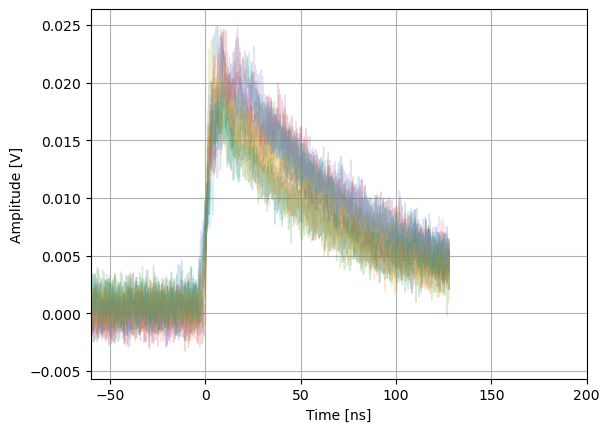

In [262]:
# for i in range(len(data_save[1])):
trace_original = []
trace_aligned = []
for i in range(len(data_save[1])):
# for i in range(100):
    trace = -data_save[1][i]
    if (max(trace)>0.025) or  (max(trace)<0.02) or (min(trace)<-0.005):
        continue
        
    # leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
    # trigger_offset = leading_edges[0][1]-2048
    
    
    trigger_offset = np.argmax( y>trigger_threshold_edge)-2048
    
    trace_original.append(trace)
    trace = np.roll(trace, -trigger_offset)
    trace_aligned.append(trace)
    
    if i <200:
        plot(time_series, trace,alpha=0.2, linewidth=1)

xlim(-60,200)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
grid()

Text(0.5, 0, 'Time [ns]')

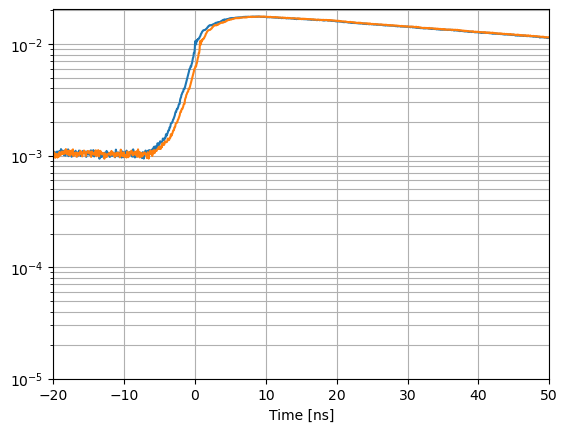

In [264]:
trace_original_avg = np.mean(trace_original, axis=0)
trace_aligned_avg = np.mean(trace_aligned, axis=0)
plot(time_series, trace_original_avg)
plot(time_series, trace_aligned_avg)

yscale("log")
xlim(-20,50)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")

In [82]:
trace_aligned_avg_all = []
for i in range(len(filenames)):
    data_save=joblib.load(filenames[i])
    time_series = data_save["metadata"]["time_series"]*1e9
    
    trace_aligned = []
    for i in range(len(data_save[1])):
        trace = data_save[1][i]
        trace-=np.mean(trace[:1600])
        trace = -trace
        trace/=15.8
        if (max(trace)>0.07) or  (max(trace)<0.01) or (min(trace)<-0.005):
            continue

        leading_edges = constant_fraction_discriminator(trace, 0, 0.01, 0.5, gauss_filter=4)
        trigger_offset = leading_edges[0][1]-2048
        trace = np.roll(trace, -trigger_offset)
        trace_aligned.append(trace)   
        
    trace_aligned_avg = np.mean(trace_aligned, axis=0)
    trace_aligned_avg_all.append(trace_aligned_avg)

Text(0, 0.5, 'Normalized amplitude')

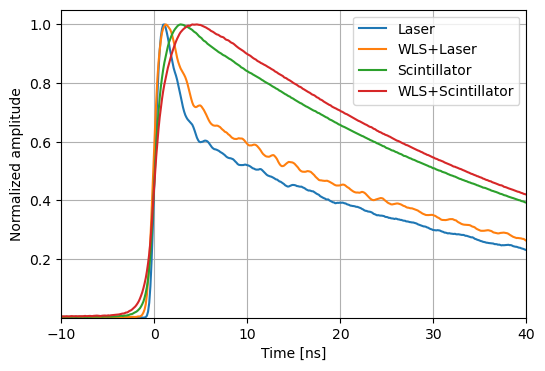

In [184]:
figure(figsize=(6,4))
for i in [0,2,1,3]:
    trace = trace_aligned_avg_all[i]
    plot(time_series, trace/max(trace),label=labels[i])
    
legend()

# yscale("log")
xlim(-10,40)
ylim(1e-5,)
grid(which="both")
xlabel("Time [ns]")
ylabel("Normalized amplitude")

In [ ]:
a=np.ones(3,">i2")